In [1]:
#! pip insatll pandas 
#! pip install numpy 
#! pip install tensorflow


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
os.listdir("./../Data/")

['best-artworks-of-all-time', 'image-classification', 'vgg19']

In [6]:
Style_Path =  "../Data/best-artworks-of-all-time/images/images/"
Content_Path = "../Data/image-classification/images/images/travel and  adventure/"

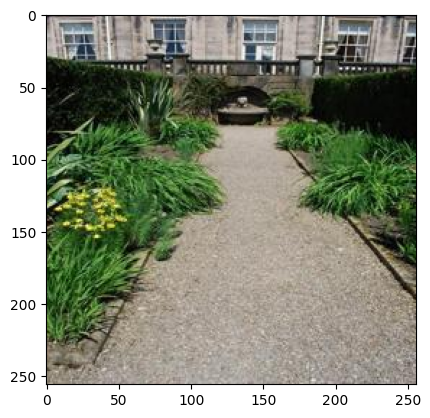

In [7]:
img1 = plt.imread(Content_Path+"Places365_val_00005732.jpg")
plt.imshow(img1)

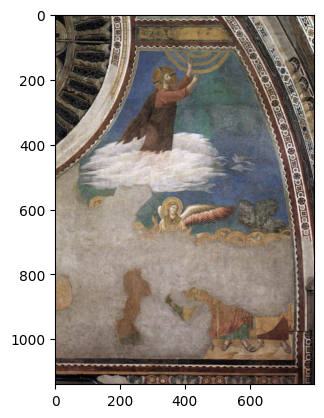

In [8]:
img2  =  plt.imread(Style_Path+"Giotto_di_Bondone/Giotto_di_Bondone_1.jpg")
plt.imshow(img2)

In [7]:
from keras import backend as K
from keras.utils import load_img,save_img,img_to_array
from keras.applications import vgg19

In [8]:
width,heigth = load_img(Content_Path+"Places365_val_00005732.jpg").size
img_rows = 400
img_cols = int(width*img_rows/heigth)
print(img_cols,img_rows)

400 400


In [9]:
def processing_images(path):
    from keras.applications import vgg19
    img = load_img(path,target_size=(img_rows,img_cols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [10]:
print(processing_images(Content_Path+"Places365_val_00005732.jpg"))

[[[[-5.9939003e+01 -8.6778999e+01 -8.2680000e+01]
   [-5.9939003e+01 -8.6778999e+01 -8.2680000e+01]
   [-9.1939003e+01 -1.1577900e+02 -1.1268000e+02]
   ...
   [-6.1939003e+01 -8.1778999e+01 -8.1680000e+01]
   [-4.9939003e+01 -6.9778999e+01 -6.9680000e+01]
   [-4.9939003e+01 -6.9778999e+01 -6.9680000e+01]]

  [[-5.9939003e+01 -8.6778999e+01 -8.2680000e+01]
   [-5.9939003e+01 -8.6778999e+01 -8.2680000e+01]
   [-9.1939003e+01 -1.1577900e+02 -1.1268000e+02]
   ...
   [-6.1939003e+01 -8.1778999e+01 -8.1680000e+01]
   [-4.9939003e+01 -6.9778999e+01 -6.9680000e+01]
   [-4.9939003e+01 -6.9778999e+01 -6.9680000e+01]]

  [[-5.1939003e+01 -7.8778999e+01 -7.4680000e+01]
   [-5.1939003e+01 -7.8778999e+01 -7.4680000e+01]
   [-6.7939003e+01 -9.1778999e+01 -8.8680000e+01]
   ...
   [-2.4939003e+01 -4.1778999e+01 -4.2680000e+01]
   [-2.7939003e+01 -4.4778999e+01 -4.5680000e+01]
   [-2.7939003e+01 -4.4778999e+01 -4.5680000e+01]]

  ...

  [[ 1.9060997e+01  2.1221001e+01  2.3320000e+01]
   [ 1.9060997e+

In [11]:
normal_image = K.variable(processing_images(Content_Path+"Places365_val_00005732.jpg"))
style_image = K.variable(processing_images(Style_Path+"Giotto_di_Bondone/Giotto_di_Bondone_1.jpg"))

In [12]:
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_rows, img_cols))
else:
    combination_image = K.placeholder((1,img_rows, img_cols,3))

In [13]:
combination_image

<KerasTensor: shape=(1, 400, 400, 3) dtype=float32 (created by layer 'input_1')>

In [14]:
input_tensor = K.concatenate([normal_image,style_image,combination_image],axis=0)

  <tf.Variable 'Variable:0' shape=(1, 400, 400, 3) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


In [15]:
from keras.applications.vgg19 import VGG19
vgg19_weights = '../Data/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [16]:
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
print("Model loaded")

Model loaded


In [17]:
content_layers = ['block5_conv2'] 

In [18]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [19]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

KerasTensor(type_spec=TensorSpec(shape=(3, 25, 25, 512), dtype=tf.float32, name=None), name='block5_conv2/Relu:0', description="created by layer 'block5_conv2'")


In [20]:
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [21]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram
def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_rows*img_cols
    return K.sum(K.square(S - C))

In [22]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')


: 

: 

In [ ]:
loss = loss + content_weight * get_content_loss(base_image_features,combination_features)
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
loss

<tf.Tensor 'add:0' shape=() dtype=float32>

In [ ]:
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 400, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 400, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 400, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 200, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 200, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 200, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 100, 256), dtype=float32)
Style Image Feature :: Tensor("strided_slice_10:0", shape=(100, 100, 256), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_11:0", shape=(100, 100, 256), dtype=float32)

Layer Feature for Style Layers :: Tensor("block4_conv1/Relu:0", shape=(3, 50, 50, 5

In [ ]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_rows, img_cols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_rows, img_cols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [ ]:
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 400, 3) dtype=float32>]

In [ ]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [2]:
x_opt = processing_images(Content_Path+"Places365_val_00005732.jpg")

NameError: name 'processing_images' is not defined

In [ ]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_rows, img_cols))
    else:
        x = x.reshape((1, img_rows, img_cols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
evaluator = Evaluator()


NameError: name 'Evaluator' is not defined

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
iterations=50
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0


NameError: name 'evaluator' is not defined